In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import torch

os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40))

In [2]:
import aPack_model
from configs import sentinel_2

/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


/data/00.Data/AO/0-Pusan-2023-AO/C1_20230116015105_10110_00006119_L1G_PS
time :  2023 1 16 10 51
202301161000_dynamic.csv
/data/00.Data/AIS-CSV-NTO-AO/2차-11개/202301161000_dynamic.csv
#------------------ : csv exists


In [3]:
'''
1. args : 이미지 경로, ais csv 경로, 탐색 옵션 등 매칭 관련 정보들 조절 
2. model_config_file : mmrotate 에서 불러들일 모델에 대한 내용들
3. check_point_file : ckpt 파일경로 
'''

args = sentinel_2
model_config_file = '/root/Ship_Detection_EO/configs/roi_trans.py'
check_point_file = '/root/Ship_Detection_EO/model_ckpts/epoch_9.pth'

In [4]:
args.model_test

True

In [5]:
args.img_path

'/data/00.Data/AO/0-Pusan-2023-AO/C1_20230116015105_10110_00006119_L1G_PS/0-Pusan-2023-AO_3_C1_20230116015105_10110_00006119_L1G.png'

In [6]:
# change img path 
args.img_path = "/root/Ship_Detection_EO/sat_image/sentinel_2/RGB.png"

In [7]:
from PIL import Image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

def get_image_shape(file_path):
    with Image.open(file_path) as img:
        width, height = img.size
        mode = img.mode

    # Determine the number of channels based on the mode
    if mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
        channels = 1
    elif mode == "L":  # 8-bit pixels, grayscale
        channels = 1
    elif mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
        channels = 1
    elif mode == "RGB":  # 3x8-bit pixels, true color
        channels = 3
    elif mode == "RGBA":  # 4x8-bit pixels, true color with transparency mask
        channels = 4
    elif mode == "CMYK":  # 4x8-bit pixels, color separation
        channels = 4
    elif mode == "YCbCr":  # 3x8-bit pixels, color video format
        channels = 3
    elif mode == "I":  # 32-bit signed integer pixels
        channels = 1
    elif mode == "F":  # 32-bit floating point pixels
        channels = 1
    else:
        raise ValueError(f"Unsupported image mode: {mode}")

    return width, height, channels

# Example usage
file_path = args.img_path
shape = get_image_shape(file_path)
print(f"Width: {shape[0]}, Height: {shape[1]}, Channels: {shape[2]}")


Width: 3151, Height: 2429, Channels: 3


In [8]:
# --------------------------------------------------------------------------------
# model inference
# --------------------------------------------------------------------------------
if args.model_test: 
    result = aPack_model.infer_model(
        input_file_path=args.img_path,
        checkpoint_file=check_point_file,
        config_file=model_config_file,
        thres=args.infer_threshold , 
        gpu_id = 0 )

torch.cuda.empty_cache()

/opt/conda/lib/python3.10/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /root/Ship_Detection_EO/model_ckpts/epoch_9.pth
#------------------- init detection
# ---- batch_size ---------------------------- # :  64
# ---- image sizes ---------------------------- # :  [32]
# ---- steps ---------------------------- # :  [26]
# ---- ratios ---------------------------- # :  [1.0]


/opt/conda/lib/python3.10/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


In [9]:
# --------------------------------------------------------------------------------
# Save result
# --------------------------------------------------------------------------------

save_root = "/root/Ship_Detection_EO/outputs"
file_name = args.img_path.split("/")[-1].split(".")[0]+".npy"    

if args.model_test == False:
    result = np.load(os.path.join(save_root,file_name))
else:
    print("Result Saved")
    np.save(os.path.join(save_root,file_name), result)

Result Saved


In [10]:
result

[array([[ 1.5979e+03,  1.8091e+02,  3.4928e+00,  3.3783e+00,  2.1834e-01,  9.1505e-02],
        [ 1.8164e+03,  8.6816e+01,  3.7880e+00,  3.3921e+00, -1.2458e+00,  8.7978e-02],
        [ 1.6983e+02,  3.9389e+01,  4.1006e+00,  3.4362e+00, -1.2820e+00,  5.4988e-02]], dtype=float32)]

In [15]:
9.1505e-02

0.091505

In [20]:
result[0][0][0]

1597.8794

In [21]:
result[0][0][1]

180.90727

In [12]:
args.infer_threshold = 0 

#--- inference threshold :  0


#-------------- 0.3333
#-------------- 0.6667
#-------------- 1.0000


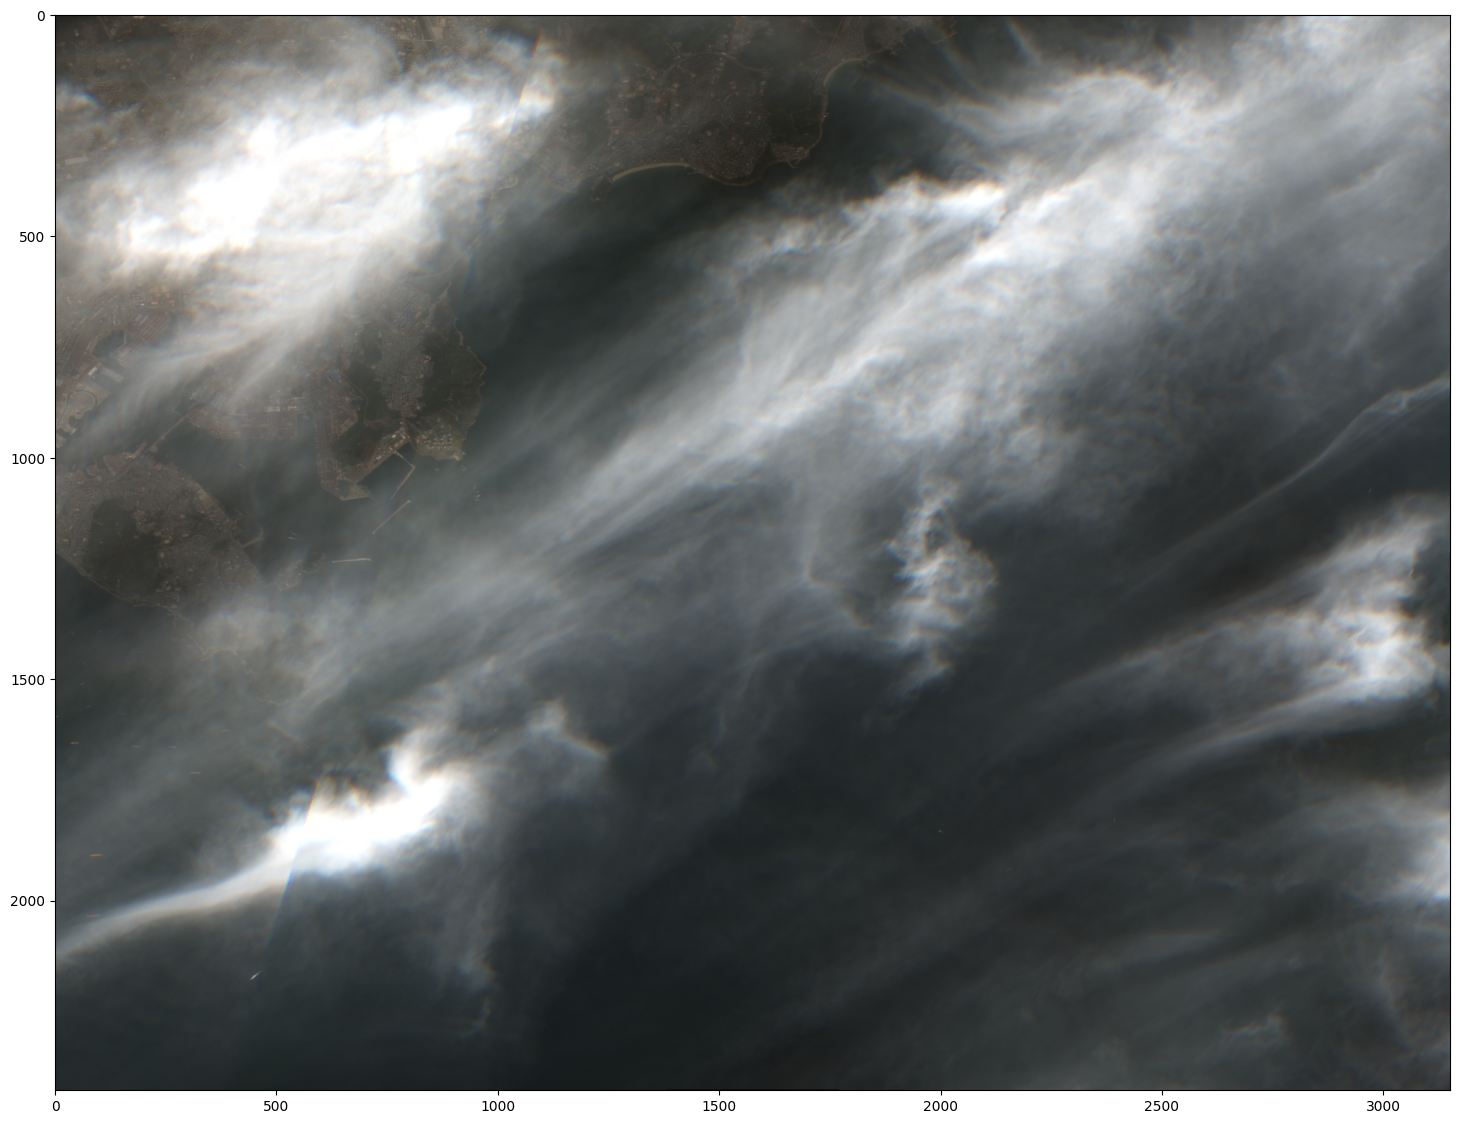

In [13]:
# --------------------------------------------------------------------------------
# Bbox Show and Save 
# --------------------------------------------------------------------------------

img_path = args.img_path
img_ = Image.open(img_path)

bboxes_ = [] 
cnt = 0

print("#--- inference threshold : ", args.infer_threshold)
for r in result[0]:
    if r[-1] > args.infer_threshold:
        cnt+=1
        bboxes_.append(r)

plt.figure(figsize=(18,18))
plt.imshow(img_)

ax = plt.gca()

box_cnt = 0
for box_ in bboxes_:
    box_cnt+=1
    print(f"#-------------- {box_cnt / len(bboxes_):.4f}")
    x = box_[0]
    y = box_[1]
    width = box_[2]
    height = box_[3]
    angle_ = box_[4]

    # model 의 객체좌표가 center 중심인데, patches.Rectangle 은 좌하단을 기준점으로 보기 때문에. x,y 를 아래와 같이 shift 
    # roatate 할 때, 중심좌표 center 로 잡고, angle radian 변환해서 넣어주기 
    path_obj = patches.Rectangle((x-width*0.5,y-height*0.5), width, height, linewidth=0.1, edgecolor="red", fill=False,
                                rotation_point="center",
                                angle=angle_*180/np.pi)
    ax.add_patch(path_obj)

plt.savefig("/root/Ship_Detection_EO/results/sentinel_2_test1111",dpi =800 )
plt.show()